# A Toy Problem - Enhanced Sampling

## Framing the Problem

Consider a system with two degrees of freedom with Hamiltonian:
$$
    H = \frac{px^2}{2m_x}\ + \frac{py^2}{2m_y}\ + \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy
$$

We can see the potential energy is:
$$
   U(x, y) = \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy 
$$

We want to calculate the marginal probability distribution function:
$$
    P(x) = \int dy e^{-\beta U(x, y)}
$$

So that we can ascertain the potential energy surface *A* of our system:
$$
    A(x) = -\frac{1}{\beta}lnP(x)

## Analytical Solution

To begin, I will calculate the marginal probability distribution analytically. This will serve as a benchmark value that I can compare to the results that I will simulate.

In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [343]:
# Constants
d = 3
a = 1
omega = 1
lam = 2.878
m_y = 1
m_x = 100

# Function for the potential energy of the system
def potential_energy(x, y):
    '''
    Function to return the potential energy of system

    @param x : x coordinate
    @param y : y coordinate
    @return en : potential energy
    '''

    # Calculate energy
    en = (d * ((x ** 2) - (a ** 2)) ** 2) + (0.5 * m_y * (omega ** 2) * (y ** 2)) + (lam * x * y)

    # Return energy
    return en

With a function to calculate potential energy, I will integrate analytically with respect to y to obtain the marginal probability distribution *P(x)* and, consequently, the free energy surface *A(x)*. This will later be compared to the result obtained by am dynamics simulation. Note that I performed integration with Mathematica due to it's superior integration capabilities compared to python libraries like SymPy.

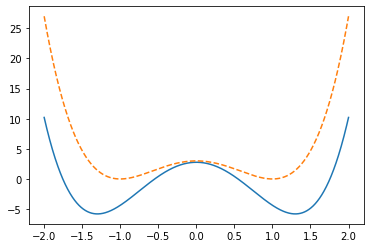

In [344]:
# Plotting Free Energy Surface
x = np.linspace(-2, 2, 1000)
fes = - np.log(1.25331 * np.exp(-((d * (a ** 2 - x ** 2) ** 2) / (a ** 4)) + ((0.5 * (x ** 2) * (lam ** 2)) / (m_y * (omega ** 2)))) / (np.sqrt(m_y) * omega)) / 1
pe = potential_energy(x, 0)
plt.plot(x, fes)
plt.plot(x, pe, linestyle='--')
plt.show()

## Numerical Solution

A numerical solution to finding the free energy surface and marginal probability distribution of the system outlined above is to simulate it with a molecular dynamics approach. By propagating a particle in time over a range of x and y values, the probability distribution along those points can be ascertained. In this problem, I will generate a particle that can move in two directions: x and y, Based on the potential acting on this particle, it's position and momentum will change in time. Specifically, I will use Langevin dynamics to propagate this particle. In Langevin dynamics, a "stochastic-dynamical" system involving position and momentum can be modeled equations:
$$
    dx = M^{-1} p dt
$$
$$
    dp = [- \nabla U(x) - \gamma] dt + \sigma M^{1/2} dW
$$
Where dx and dp are changes in position and momentum respectively, M is a mass or diagonal matrix of masses, gamma is a friction coefficient, and W is a Wiener process or a vector of Wiener processes. Leimkuhler and Matthews derive the equations of motion (EOMs) shown above for Langevin dynamical systems. These equations maintain temperature by modulating the momentum of the system.

### My algorithm

1. Initialize coordinate, choose v<sub>x</sub> and v<sub>y</sub>.
2. Compute forces $$F = -\nabla U(x, y)$$
3. Update position and momentum (BAOAB integrator, follows from Langevin Dynamics)
4. Update time $$ t = t + \Delta t$$
5. Repeat steps 2 through 4 for n timesteps.

## Choice of Integrator

I will be implementing the BAOAB integrator, these equations below follow from Langevin dynamics. This integrator has the following equations of motion:

$$
    p_{n+1/2} = p_n - \delta t \nabla U(x_n)/2:
$$
$$
    x_{n+1/2} = x_n + \delta t M^{-1} p_{n+1/2}/2;
$$
$$
    \hat{p}_{n+1/2} = c_1 p_{n+1/2} + c_3 M^{1/2} R_{n+1};
$$
$$
    x_{n+1} = x_{n+1/2} + \delta t M^{-1} \hat{p}_{n+1/2}/2;
$$
$$
    p_{n+1} = \hat{p}_{n+1/2} - \delta t \nabla U(x_{n+1})/2;
$$

Where:
$$
    c_1 = e^{-\gamma \delta t}, \quad c_2 = \gamma^{-1}(1-c_1), \quad c_3 = \sqrt{k_BT(1-c_1^2)}
$$

where I will set &gamma; to be 1

A numerical solution requires simulating a particle in the x and y space we have constrained our system to. In order to do this we must initialize a system with x and y coordinates at time of 0 seconds. We also need to specify temperature and masses for x and y directions.

In [361]:
def grad(point):
    '''
    Function to calculate the gradient of the potential V(x, y) with respect to x

    @param point : point to evaluate gradient

    @return grad : the gradient
    '''

    # Set x and y
    x = point[0]
    y = point[1]

    # Calculate gradient
    grad_x = (((4 * d) / (a ** 4)) * x * ((x ** 2) - (a ** 2))) + (y * lam)
    grad_y = ((m_y * (omega ** 2) * y) + (lam * x))
    gradient = (grad_x, grad_y)

    # Return gradient
    return gradient

def run_simulation(n_steps, m_x, m_y, kt_x, kt_y):
    '''
    Function to run simulation for x timesteps

    @param n_steps : number of timesteps to take
    @param m_x : mass for x-coordinate
    @param t_x : temperature for x-coordinate
    @param m_y : mass for y-coordinate
    @param t_y : temperature for y_coordinate

    @return x_pos : x-coordinate data
    @return free_en : free energy at each x position
    '''

    # Lists for data collection 
    steps = []
    x_pos = []  # Values for x at each step
    y_pos = []  # Values for y at each step
    p_square = []   # Momentum squared at each step

    '''
    Step 1: Initialize system

    Set coordinate and choose a random velocity to initialize system, momenta will
    evolve through equations of motion after this step so velocity does not need to be
    tracked throughout the simulation.
    '''
    coords = [-1, 1]
    velocity = [random.gauss(0, 1), random.gauss(0, 1)]
    momenta = [m_x * velocity[0], m_y * velocity[1]]
    time = 0
    time_step = 0.25 * (10 ** -3)

    # Initialize constants
    c1 = np.exp(-1 * time_step)
    c3_x = np.sqrt(kt_x * (1 - (c1 ** 2)))
    c3_y = np.sqrt(kt_y * (1 - (c1 ** 2)))

    # Simulation loop
    for i in range(n_steps):

        '''
        Step 2: Compute forces

        Forces are negative gradient of the potential.
        '''
        gradient = grad(coords)

        '''
        Step 3: Move coordinate
        
        Integrate the Langevin dynamics equations of motion to conserve momenta and, thus, temperature.
        '''
        # B
        p_int_x = momenta[0] - (time_step * gradient[0]) / 2
        p_int_y = momenta[1] - (time_step * gradient[1]) / 2
 
        # A
        x_int = coords[0] + (time_step * (m_x ** -1) * p_int_x) / 2
        y_int = coords[1] + (time_step * (m_y ** -1) * p_int_y) / 2

        # O
        p_int_x = (c1 * p_int_x) + (c3_x * (m_x ** (1/2)) * random.gauss(0, 1))
        p_int_y = (c1 * p_int_y) + (c3_y * (m_y ** (1/2)) * random.gauss(0, 1))

        # A
        x_new = x_int + (time_step * (m_x ** -1) * p_int_x) / 2
        y_new = y_int + (time_step * (m_y ** -1) * p_int_y) / 2

        # Compute NEW gradient for final equations
        new_gradient = grad([x_new, y_new])

        # B
        p_new_x = p_int_x - (time_step * new_gradient[0]) / 2
        p_new_y = p_int_y - (time_step * new_gradient[1]) / 2

        # Set new coordinates and momenta
        coords[0], coords[1] = x_new, y_new
        momenta[0], momenta[1] = p_new_x, p_new_y

        '''
        Step 4: Accelerate time
        
        Add timestep to current time.
        '''
        time = time + time_step

        # Record values and repeat
        steps.append(i+1)
        x_pos.append(coords[0])
        y_pos.append(coords[1])
        p_square.append(momenta[0] ** 2)
        
    # Return data
    return x_pos, y_pos, p_square, steps

## Simulation Testing

Below is code for testing the simulation written above and analyzing resulting data. Relevant figures like x position over time can be generated and used to visualize the movement of the particle and the free energy of the system.

In [360]:
# Run simulation for same and different mass/temperature
n_steps = 1000000
x2, y2, p_square2, steps2 = run_simulation(n_steps, 300, 1, 15, 1)

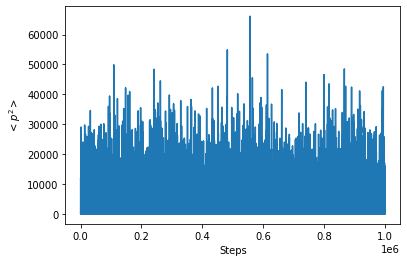

In [357]:
#Plot momentum squared over time
idx = n_steps
plt.xlabel('Steps')
plt.ylabel('$<p^{2}>$')
plt.plot(steps2[:idx], p_square2[:idx])
plt.show()

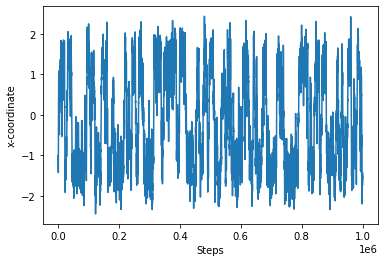

In [358]:
#Plot momentum squared over time
plt.xlabel('Steps')
plt.ylabel('x-coordinate')
plt.plot(steps2[:idx], x2[:idx])

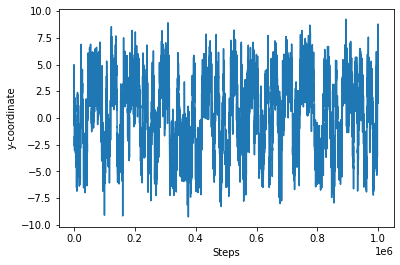

In [359]:
#Plot momentum squared over time
plt.xlabel('Steps')
plt.ylabel('y-coordinate')
plt.plot(steps2[:idx], y2[:idx])